<a href="https://colab.research.google.com/github/Geringer13/Netology_pyda/blob/master/Final_work_Creating_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np
import statistics
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve
import seaborn as sns
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, AffinityPropagation
from sklearn.metrics import adjusted_rand_score, silhouette_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

Item_Identifier - Id продукта

Item_Weight - Вес продукта

Item_Fat_Content - Содержание жира в продукте

Item_Visibility - %полок, отведенный под наш продукт в конкретном магазине

Item_Type - Категория продукта

Item_MRP - Максимальная цена продажи продукта

Outlet_Identifier - Идентификатор магазина

Outlet_Establishment_Year - Год открытия магазина

Outlet_Size - Площадь магазина

Outlet_Location_Type - Тип города, в котором расположен магазин

Outlet_Type - Признак является ли магазин продуктовым или супермаркетом

Item_Outlet_Sales - Продажи продукта в конкретном магазине. Именно ее и надо предсказывать


**Read the file**

In [3]:
data = pd.read_csv('data.csv')
data.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


**Explore dataset with info, describe etc**

In [4]:
len(data)

8523

In [0]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
Item_Identifier              8523 non-null object
Item_Weight                  7060 non-null float64
Item_Fat_Content             8523 non-null object
Item_Visibility              8523 non-null float64
Item_Type                    8523 non-null object
Item_MRP                     8523 non-null float64
Outlet_Identifier            8523 non-null object
Outlet_Establishment_Year    8523 non-null int64
Outlet_Size                  6113 non-null object
Outlet_Location_Type         8523 non-null object
Outlet_Type                  8523 non-null object
Item_Outlet_Sales            8523 non-null float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


In [0]:
data.isnull().sum()

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

In [0]:
data.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,7060.000000,8523.000000,8523.000000,8523.000000,8523.000000
mean,12.857645,0.066132,140.992782,1997.831867,2181.288914
std,4.643456,0.051598,62.275067,8.371760,1706.499616
min,4.555000,0.000000,31.290000,1985.000000,33.290000
25%,8.773750,0.026989,93.826500,1987.000000,834.247400
50%,12.600000,0.053931,143.012800,1999.000000,1794.331000
75%,16.850000,0.094585,185.643700,2004.000000,3101.296400
max,21.350000,0.328391,266.888400,2009.000000,13086.964800


**We have two columns with NaN values, its Weight and Size. Let`s deal with this, I suggest fill weight NaN values with mean(), and size NaN values transform into 4th feature of a size type.**

Process size feature

In [0]:
# Let`s make 4th feature - another type
data['Outlet_Size'].value_counts()

Medium    2793
Small     2388
High       932
Name: Outlet_Size, dtype: int64

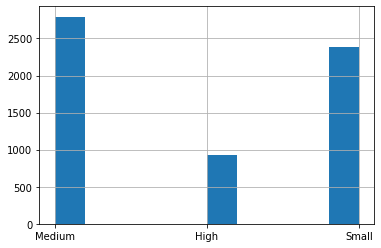

In [0]:
data['Outlet_Size'].hist()

In [0]:
data['Outlet_Size'] = data['Outlet_Size'].fillna('Another')

Medium     2793
Another    2410
Small      2388
High        932
Name: Outlet_Size, dtype: int64


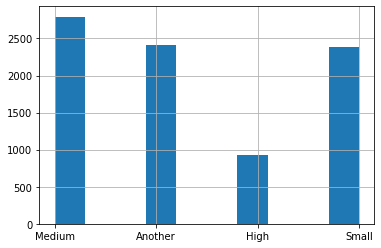

In [6]:
data['Outlet_Size'].hist()
print(data['Outlet_Size'].value_counts())

Process weight feature, fill NaN values with mean() according to a item type 

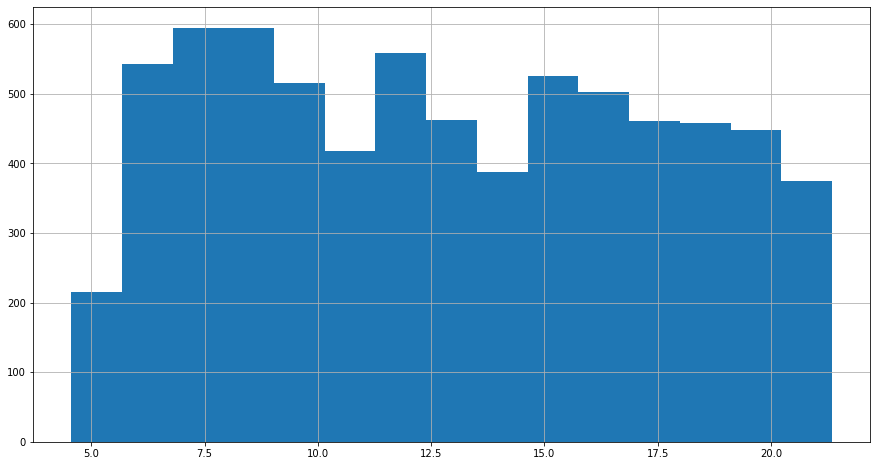

In [0]:
plt.figure(figsize=(15,8))
data['Item_Weight'].hist(bins=15)
plt.show()

In [0]:
# we see that amounts of NaN weight valeus equal 1463 records, its huge number

print(data['Item_Weight'].value_counts())
print(data['Item_Weight'].isna().sum())

12.150    86
17.600    82
13.650    77
11.800    76
15.100    68
          ..
7.560      2
9.420      1
5.400      1
6.520      1
7.685      1
Name: Item_Weight, Length: 415, dtype: int64
1463


In [0]:
data['Item_Type'].unique()

array(['Dairy', 'Soft Drinks', 'Meat', 'Fruits and Vegetables',
       'Household', 'Baking Goods', 'Snack Foods', 'Frozen Foods',
       'Breakfast', 'Health and Hygiene', 'Hard Drinks', 'Canned',
       'Breads', 'Starchy Foods', 'Others', 'Seafood'], dtype=object)

In [0]:
# let`s fill NAN values with the mode values for each type
# first of all estimate mean values for each type and put it in new dataframe
mean = data.groupby('Item_Type').apply(lambda data: data['Item_Weight'].mean())

In [12]:
mean = pd.DataFrame(mean)
mean = mean.reset_index()
mean.head()

,index,Item_Type,0
0,0,Baking Goods,12.277108
1,1,Breads,11.346936
2,2,Breakfast,12.768202
3,3,Canned,12.305705
4,4,Dairy,13.426069


In [0]:
mean = mean.drop('index', axis=1)

In [14]:
mean.columns = ['Item_Type', 'mean']
mean

,Item_Type,mean
0,Baking Goods,12.277108
1,Breads,11.346936
2,Breakfast,12.768202
3,Canned,12.305705
4,Dairy,13.426069
5,Frozen Foods,12.867061
6,Fruits and Vegetables,13.224769
7,Hard Drinks,11.400328
8,Health and Hygiene,13.142314
9,Household,13.384736


In [15]:
# merge general dataframe with mode
data = data.merge(mean, how='left')
data.head(10)

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,mean
0,FDA15,9.300,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380,13.426069
1,DRC01,5.920,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228,11.847460
2,FDN15,17.500,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700,12.817344
3,FDX07,19.200,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,Another,Tier 3,Grocery Store,732.3800,13.224769
4,NCD19,8.930,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052,13.384736
5,FDP36,10.395,Regular,0.000000,Baking Goods,51.4008,OUT018,2009,Medium,Tier 3,Supermarket Type2,556.6088,12.277108
6,FDO10,13.650,Regular,0.012741,Snack Foods,57.6588,OUT013,1987,High,Tier 3,Supermarket Type1,343.5528,12.987880
7,FDP10,NaN,Low Fat,0.127470,Snack Foods,107.7622,OUT027,1985,Medium,Tier 3,Supermarket Type3,4022.7636,12.987880
8,FDH17,16.200,Regular,0.016687,Frozen Foods,96.9726,OUT045,2002,Another,Tier 2,Supermarket Type1,1076.5986,12.867061
9,FDU28,19.200,Regular,0.094450,Frozen Foods,187.8214,OUT017,2007,Another,Tier 2,Supermarket Type1,4710.5350,12.867061


In [0]:
data['Item_Weight'] = data['Item_Weight'].fillna('nothing')

In [0]:
data.loc[data['Item_Weight']=='nothing', 'Item_Weight'] = data['mean']

In [0]:
data = data.drop('mean', axis=1)

In [20]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                8523 non-null   object 
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                8523 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(3), int64(1), object(8)
memory usage: 1.2+ MB


Nice, we have filled all nan values, lets research our data

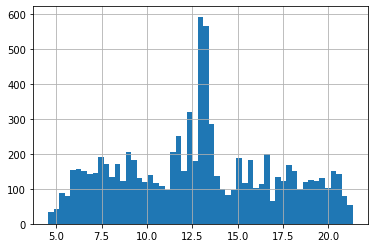

In [21]:
# let`s look for different distributions
data['Item_Weight'].hist(bins=55)

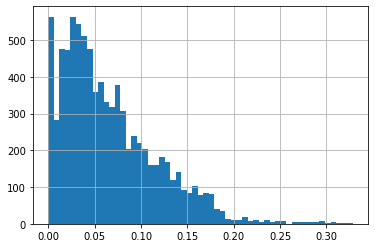

In [22]:
data['Item_Visibility'].hist(bins=55)

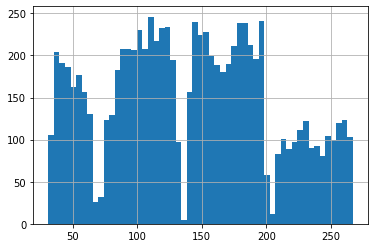

In [23]:
data['Item_MRP'].hist(bins=55)

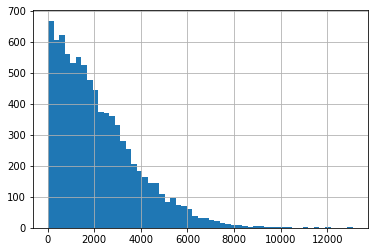

In [24]:
data['Item_Outlet_Sales'].hist(bins=55)

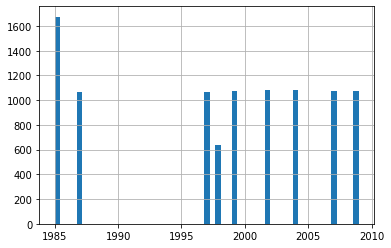

In [0]:
data['Outlet_Establishment_Year'].hist(bins=55)

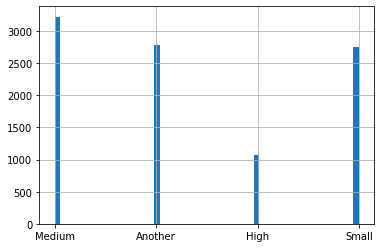

In [0]:
data['Outlet_Size'].hist(bins=55)

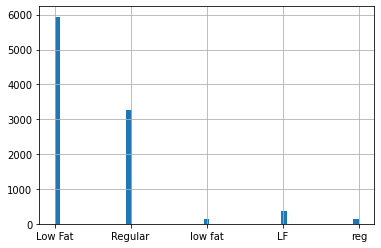

In [0]:
data['Item_Fat_Content'].hist(bins=55)

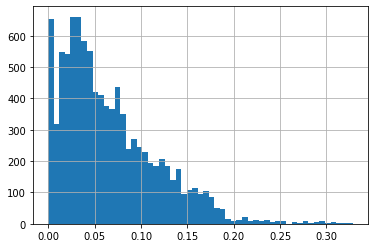

In [0]:
data['Item_Visibility'].hist(bins=55)

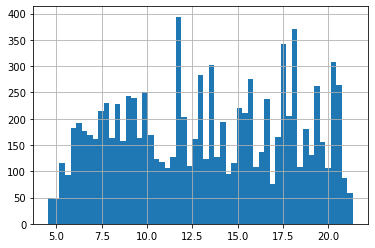

In [0]:
data['Item_Weight'].hist(bins=55)

In [0]:
# look at sales rating according to different features
sales = data.groupby('Item_Type').sum().sort_values('Item_Outlet_Sales', ascending=True).reset_index()

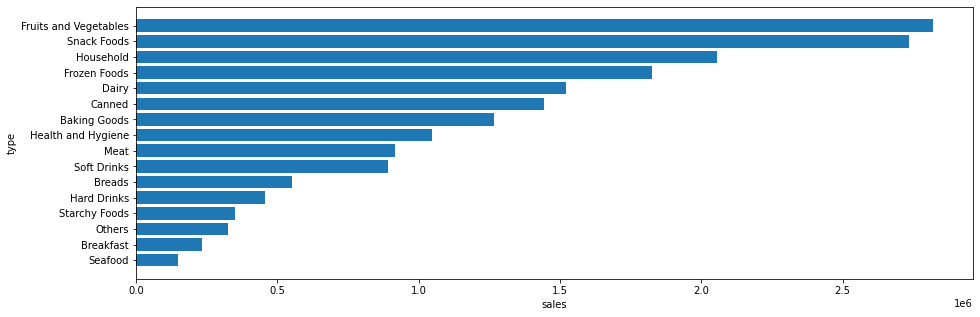

In [26]:
plt.figure(figsize=(15,5))
plt.barh(sales['Item_Type'], sales['Item_Outlet_Sales'])
plt.xlabel('sales')
plt.ylabel('type')
plt.show()

In [0]:
sales2 = data.groupby('Item_Fat_Content').sum().sort_values('Item_Outlet_Sales', ascending=True).reset_index()

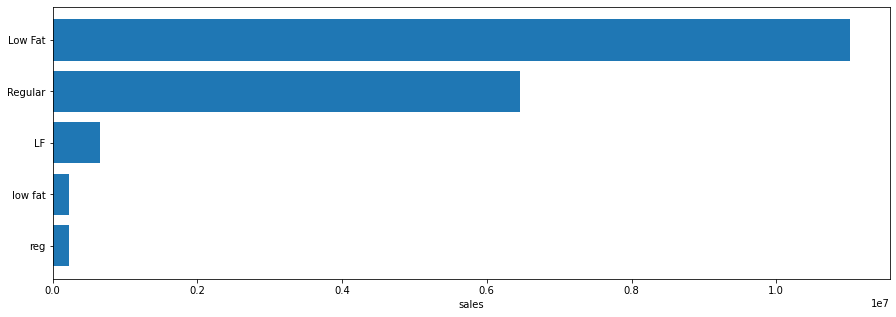

In [28]:
plt.figure(figsize=(15,5))
plt.barh(sales2['Item_Fat_Content'], sales2['Item_Outlet_Sales'])
plt.xlabel('sales')
plt.show()

In [0]:
sales3 = data.groupby('Outlet_Size').sum().sort_values('Item_Outlet_Sales', ascending=True).reset_index()

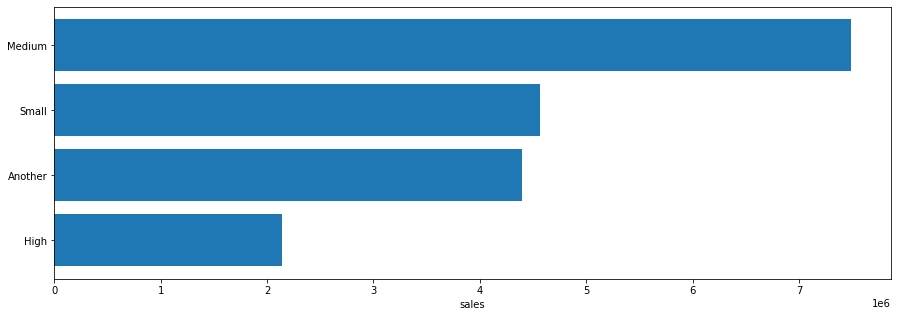

In [30]:
plt.figure(figsize=(15,5))
plt.barh(sales3['Outlet_Size'], sales3['Item_Outlet_Sales'])
plt.xlabel('sales')
plt.show()

In [0]:
sales4 = data.groupby('Outlet_Identifier').sum().sort_values('Item_Outlet_Sales', ascending=True).reset_index()

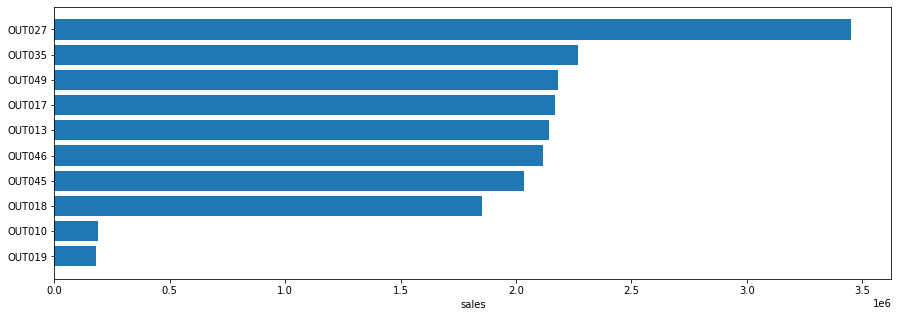

In [32]:
plt.figure(figsize=(15,5))
plt.barh(sales4['Outlet_Identifier'], sales4['Item_Outlet_Sales'])
plt.xlabel('sales')
plt.show()

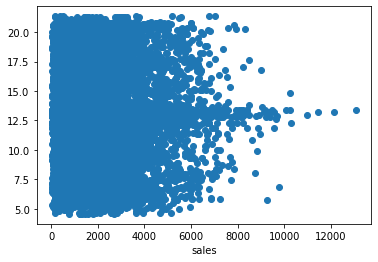

In [33]:
# lets look at sales correlation with different features

plt.scatter(data['Item_Outlet_Sales'], data['Item_Weight'])
plt.xlabel('sales')
plt.show()

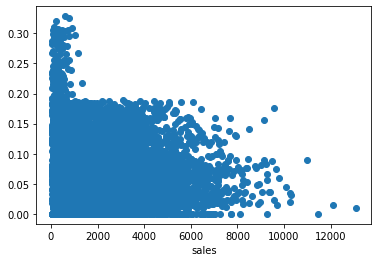

In [34]:
plt.scatter(data['Item_Outlet_Sales'], data['Item_Visibility'])
plt.xlabel('sales')
plt.show()

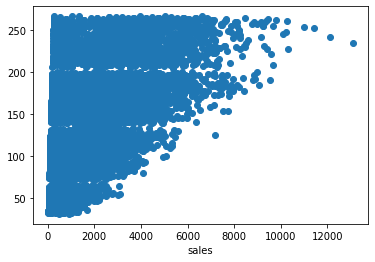

In [35]:
plt.scatter(data['Item_Outlet_Sales'], data['Item_MRP'])
plt.xlabel('sales')
plt.show()

So, we need to process categorical features to get more information about correlation in data

In [0]:
# let`s use label encoder for processing categorical features
le = LabelEncoder()

In [0]:
data['Item_Fat_Content'] = le.fit_transform(data['Item_Fat_Content'])
data['Item_Type'] = le.fit_transform(data['Item_Type'])
data['Outlet_Size'] = le.fit_transform(data['Outlet_Size'])
data['Outlet_Location_Type'] = le.fit_transform(data['Outlet_Location_Type'])
data['Outlet_Type'] = le.fit_transform(data['Outlet_Type'])
data['Outlet_Establishment_Year'] = le.fit_transform(data['Outlet_Establishment_Year'])

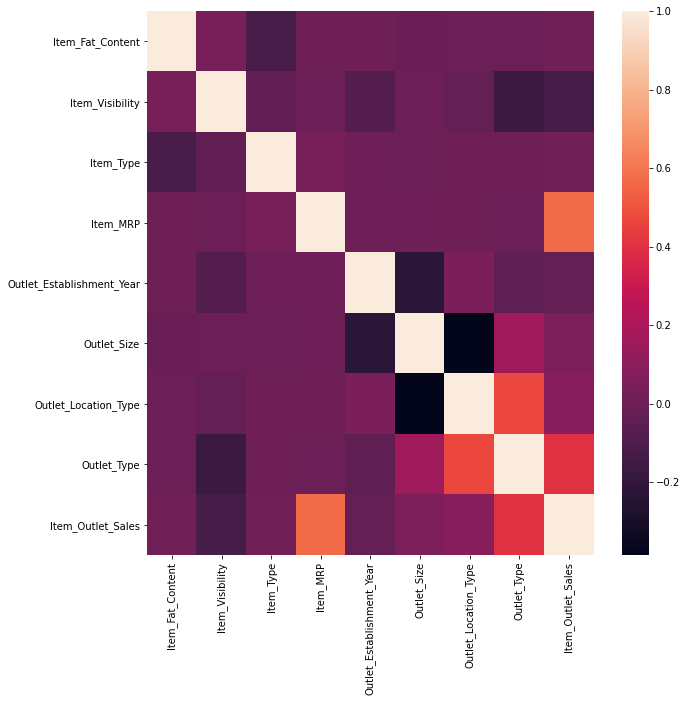

In [38]:
plt.figure(figsize=(10,10))
sns.heatmap(data.corr())

So, let`s try to build up the models: Linearregression and RandomForrest. Im going to use MAE - mean absolute error to evaluate model results because we will predict sales numbers, this is continuous values.

In [0]:
data_scal = data[['Item_MRP', 'Outlet_Location_Type', 'Outlet_Type', 'Item_Outlet_Sales']]
headers = data_scal.columns

In [0]:
scaler = StandardScaler()
data_scal = scaler.fit_transform(data_scal)

In [0]:
data_scal = pd.DataFrame(data_scal)
data_scal.columns = headers

In [0]:
# for linear model I will leave only three feature which have the largest data correlation
X = data_scal[['Item_MRP', 'Outlet_Location_Type', 'Outlet_Type']]
y = data_scal['Item_Outlet_Sales']

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [0]:
model_lin = LinearRegression()
model_lin.fit(X_train, y_train)
prediction_lin = model_lin.predict(X_test)

In [47]:
model_lin.score(X_test, y_test)

0.5261590515940961

In [48]:
print("MAE: \t", mean_absolute_error(y_test, prediction_lin))

MAE: 	 0.5161532231684581


In [0]:
# for i, j in zip(y_test, prediction_lin):
#     print('target:', i, 'pred:', j)

In [54]:
# let`s try polynomial regression
from sklearn.preprocessing import PolynomialFeatures
poly_reg = PolynomialFeatures(degree=4)
X_poly = poly_reg.fit_transform(X_train)
pol_reg = LinearRegression()
pol_reg.fit(X_poly, y_train)
# prediction_poly = model_lin.predict(X_poly)
pol_reg.score(poly_reg.fit_transform(X_test), y_test)

0.6213526954899234

In [0]:
# print("MAE: \t", mean_absolute_error(y_test, prediction_lin))

In [57]:
data_proba = data[data['Item_Outlet_Sales']<= 5000] 
data_proba.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.3,1,0.016047,4,249.8092,OUT049,4,2,0,1,3735.1380
1,DRC01,5.92,2,0.019278,14,48.2692,OUT018,8,2,2,2,443.4228
2,FDN15,17.5,1,0.016760,10,141.6180,OUT049,4,2,0,1,2097.2700
3,FDX07,19.2,2,0.000000,6,182.0950,OUT010,3,0,2,0,732.3800
4,NCD19,8.93,1,0.000000,9,53.8614,OUT013,1,1,2,1,994.7052


In [0]:
# two times
data_proba = data_proba.sort_values(by='Item_Outlet_Sales',ascending=True).reset_index()

In [0]:
data_proba = data_proba.drop('index', axis=1)

In [0]:
data_proba = data_proba.applymap(lambda x: int(x) if isinstance(x, float) else x)

In [0]:
data_proba.loc[:2888, 'level_0'] = '1'
data_proba.loc[2888:5403, 'level_0'] = '2'
data_proba.loc[5404:7234, 'level_0'] = '3'
data_proba.loc[7234:8434, 'level_0'] = '4'
data_proba.loc[8434:, 'level_0'] = '5'

In [62]:
data_proba

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,level_0
0,NCR42,9,1,0,9,33,OUT010,3,0,2,0,33,1
1,DRK12,9,1,0,14,32,OUT010,3,0,2,0,33,1
2,FDU21,12,2,0,13,35,OUT019,0,3,0,0,33,1
3,NCL41,13,1,0,8,34,OUT019,0,3,0,0,34,1
4,FDQ47,7,2,0,1,33,OUT010,3,0,2,0,35,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7889,FDU14,17,1,0,4,248,OUT045,5,0,1,1,4993,4
7890,FDF05,17,1,0,5,264,OUT013,1,1,2,1,4996,4
7891,FDF39,14,2,0,4,262,OUT046,2,3,0,1,4996,4
7892,FDK40,7,0,0,5,263,OUT049,4,2,0,1,4996,4


In [0]:
X_1 = data_proba.drop(['level_0', 'Item_Outlet_Sales', 'Item_Identifier', 'Outlet_Identifier'], axis=1)
y_1 = data_proba['level_0']

In [0]:
X_1train, X_1test, y_1train, y_1test = train_test_split(X_1, y_1, test_size=0.3)

In [0]:
dt = DecisionTreeClassifier(max_depth=5, min_samples_leaf=20, max_features=0.5)

In [72]:
dt.fit(X_1train, y_1train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=5, max_features=0.5, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=20, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

''

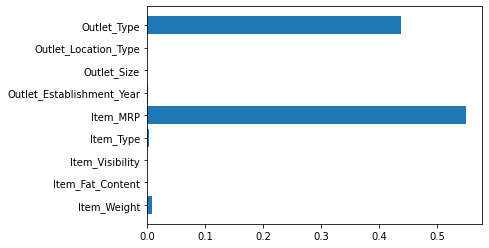

In [73]:
# the most important features
plt.barh(np.arange(len(dt.feature_importances_)), dt.feature_importances_)
plt.yticks(np.arange(len(X_1.columns)),X_1.columns)
''

In [74]:
dt.score(X_1test, y_1test)

0.5808357956943858

In [75]:
dt.predict(X_1test)

array(['1', '2', '1', ..., '1', '3', '1'], dtype=object)

In [0]:
a=[]
for i, j in zip(y_1train, dt.predict(X_1test)):
    a.append(int(i)- int(j))
    # print('target:', i, 'pred:', j, 'diff: ', int(i)- int(j))

In [80]:
b = pd.DataFrame(a)
b.reset_index()

,index,0
0,0,0
1,1,1
2,2,2
3,3,-1
4,4,0
...,...,...
2364,2364,1
2365,2365,-2
2366,2366,3
2367,2367,-2


In [0]:
b.columns=['1']

In [82]:
b['1'].value_counts()

 0    670
-1    585
 1    471
-2    347
 2    226
 3     62
-3      8
Name: 1, dtype: int64

In [0]:
yval_pred_proba = dt.predict_proba(X_1test)
yval_pred_proba

array([[0.00775194, 0.10852713, 0.20930233, 0.3875969 , 0.28682171],
       [1.        , 0.        , 0.        , 0.        , 0.        ],
       [0.16666667, 0.31666667, 0.34166667, 0.16666667, 0.00833333],
       ...,
       [0.0326087 , 0.59782609, 0.30434783, 0.04347826, 0.02173913],
       [1.        , 0.        , 0.        , 0.        , 0.        ],
       [0.52222222, 0.42222222, 0.05555556, 0.        , 0.        ]])

In [68]:
clf_rf = RandomForestClassifier(n_estimators=10, max_depth=5, min_samples_leaf=20, max_features=0.5, n_jobs=-1)
clf_rf.fit(X_1train, y_1train)   

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5, max_features=0.5,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=20, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
                       oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [83]:
clf_rf.score(X_1test, y_1test)

0.5854791051076403

In [0]:
k_range = list(range(1, 10))

In [0]:
param_grid = dict(n_neighbors=k_range)

In [0]:
grid = GridSearchCV(KNeighborsClassifier(), param_grid=param_grid, cv=10, scoring='accuracy')

In [100]:
grid.fit(X_1, y_1)

GridSearchCV(cv=10, error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=None,
             param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=0)

In [101]:
for k in grid.cv_results_:
    print(k, ":", grid.cv_results_[k][0])

mean_fit_time : 0.015323519706726074
std_fit_time : 0.0015798849707931604
mean_score_time : 0.025203490257263185
std_score_time : 0.0005047811360281564
param_n_neighbors : 1
params : {'n_neighbors': 1}
split0_test_score : 0.5455696202531646
split1_test_score : 0.49746835443037973
split2_test_score : 0.5012658227848101
split3_test_score : 0.4911392405063291
split4_test_score : 0.45373891001267425
split5_test_score : 0.4512040557667934
split6_test_score : 0.5006337135614702
split7_test_score : 0.4512040557667934
split8_test_score : 0.43599493029150826
split9_test_score : 0.41698352344740175
mean_test_score : 0.4745202226821325
std_test_score : 0.036826467490467654
rank_test_score : 9


In [102]:
test_scores = grid.cv_results_['mean_test_score']
print(test_scores)

[0.47452022 0.47896424 0.48377324 0.49581557 0.49809068 0.49923232
 0.49631853 0.49948934 0.49518105]


Text(0, 0.5, 'Cross-Validated Accuracy')

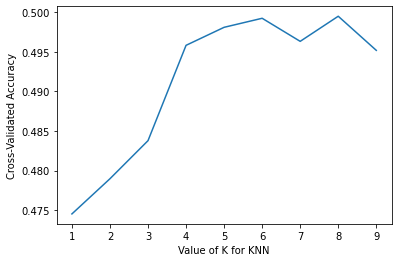

In [103]:
plt.plot(k_range, test_scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-Validated Accuracy')

In [104]:
# Single best score achieved across all params (k)
print(grid.best_score_)

# Dictionary containing the parameters (k) used to generate that score
print(grid.best_params_)

# Actual model object fit with those best parameters
# Shows default parameters that we did not specify
print(grid.best_estimator_)

0.49948933917312416
{'n_neighbors': 8}
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=8, p=2,
                     weights='uniform')


**Что и требовалось доказать) 49%)))**

In [0]:
predictions = clf_rf.predict(X_1test)

''

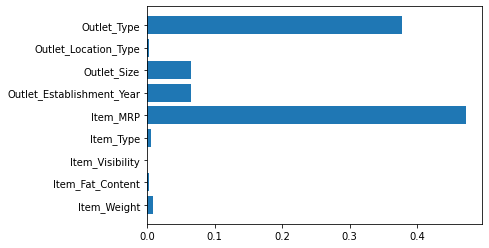

In [94]:
# the most important features
plt.barh(np.arange(len(clf_rf.feature_importances_)), clf_rf.feature_importances_)
plt.yticks(np.arange(len(X_1.columns)),X_1.columns)
''

In [90]:
c = []
for i, j in zip(y_1train, predictions):
    c.append(int(i)- int(j))
    print('target:', i, 'pred:', j, 'diff: ', int(i)- int(j))

target: 1 pred: 1 diff:  0
target: 3 pred: 2 diff:  1
target: 3 pred: 1 diff:  2
target: 2 pred: 3 diff:  -1
target: 1 pred: 1 diff:  0
target: 3 pred: 1 diff:  2
target: 3 pred: 2 diff:  1
target: 2 pred: 3 diff:  -1
target: 2 pred: 3 diff:  -1
target: 1 pred: 3 diff:  -2
target: 1 pred: 2 diff:  -1
target: 1 pred: 1 diff:  0
target: 1 pred: 1 diff:  0
target: 1 pred: 1 diff:  0
target: 1 pred: 2 diff:  -1
target: 2 pred: 1 diff:  1
target: 2 pred: 2 diff:  0
target: 1 pred: 1 diff:  0
target: 1 pred: 1 diff:  0
target: 3 pred: 2 diff:  1
target: 3 pred: 2 diff:  1
target: 2 pred: 2 diff:  0
target: 2 pred: 3 diff:  -1
target: 1 pred: 3 diff:  -2
target: 1 pred: 3 diff:  -2
target: 1 pred: 1 diff:  0
target: 1 pred: 2 diff:  -1
target: 1 pred: 2 diff:  -1
target: 1 pred: 2 diff:  -1
target: 1 pred: 1 diff:  0
target: 3 pred: 2 diff:  1
target: 3 pred: 2 diff:  1
target: 1 pred: 1 diff:  0
target: 2 pred: 1 diff:  1
target: 1 pred: 2 diff:  -1
target: 2 pred: 2 diff:  0
target: 4 pred:

In [91]:
c = pd.DataFrame(c)
c.reset_index()

,index,0
0,0,0
1,1,1
2,2,2
3,3,-1
4,4,0
...,...,...
2364,2364,1
2365,2365,-2
2366,2366,3
2367,2367,-2


In [0]:
c.columns=['1']

In [93]:
c['1'].value_counts()

 0    671
-1    615
 1    516
 2    263
-2    235
 3     65
-3      4
Name: 1, dtype: int64